In [57]:
import numpy as np
from pathlib import Path
import os
from osgeo import gdal
from skimage.util.shape import view_as_windows
import imageio

In [264]:
root_dir = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches')
test_path = root_dir / 'Test' / 'Labels'

In [265]:
filenames = os.listdir(test_path)
filenames.sort()
print(len(filenames))

8280


In [251]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

tif_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/test.tif'
# 0-12->2020, 13-22->2021, 23-36-> 2022
img_test = load_tif_image(tif_path)
print(img_test[3:].shape)
img_test = img_test[:, :2304, :2944]

(33, 2332, 3004)


In [168]:
mask_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/area.tif'
mask = load_tif_image(mask_path)
mask = mask[:2304, :2944]
print(mask.shape)
mask[mask == 0.0] = 2.0
mask[mask == 1] = 0.0
for i in range(img_test.shape[0]):
    img_test[i, :, :][mask == 2.0] = 2.0

(2304, 2944)


In [256]:
img_test_tri = img_test.reshape((3, -1, img_test.shape[1], img_test.shape[2]))
img_test_tri = img_test_tri.max(axis=0)
print(img_test_tri.shape)
for i in range(img_test_tri.shape[0]):
    img_test_tri[i, :, :][mask == 2.0] = 2.0

(12, 2304, 2944)


In [120]:
def extract_patches(image: np.ndarray, patch_size: int, stride: int) -> np.ndarray:
    window_shape_array = (image.shape[0], patch_size, patch_size)
    return np.array(view_as_windows(image, window_shape_array, step=stride)).reshape((-1,) + window_shape_array)
print(2332 // 64, 36*64, 3004 // 64, 46*64)

patch_size = 64
patches = extract_patches(img_test[3:, :2304, :2944], patch_size=patch_size, stride=patch_size)
print(patches.shape)
img_rec2 = patches.reshape(img_test[3:, :2304, :2944].shape)
print(img_rec2.shape)
for i in range(img_rec2.shape[0]):
    img_rec2[i, :, :][mask == 2.0] = 2.0


36 2304 46 2944
(1656, 33, 64, 64)
(33, 2304, 2944)


In [257]:
folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'img_test_trimestre.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration = 1) as writer:
    for idx, frame in enumerate(img_test_tri):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

Saving GIF file
Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12


In [273]:
patches_pred = []
print(patches.shape)

# for i in range(patches.shape[0]):
print(len(filenames) // 5)
for i in range(len(filenames) // 5):
    same_patches = []
    for j in range(5):
        filename = Path(f'patch={i}_trimester_window={j}.npy')
        print(test_path / filename)
        patch = np.load(test_path / filename)
        print(patch.shape)
        same_patches.append(patch)
        # print(np.expand_dims(patch[:, 0], axis=1).shape)
        # print(patch.shape)
        # if j == 0:
        #     # print(patch.shape)
        #     same_patches.append(patch)
        # else:
        #     print(np.expand_dims(patch[:, -1], axis=1).shape)
        #     same_patches.append(np.expand_dims(patch[:, -1], axis=1))
    print(np.stack(same_patches, axis=0).shape)
    patches_pred.append(np.stack(same_patches, axis=0))
# for filename in filenames:
#     print(filename)

(1656, 33, 64, 64)
1656
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=0_trimester_window=0.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=0_trimester_window=1.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=0_trimester_window=2.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=0_trimester_window=3.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=0_trimester_window=4.npy
(64, 64)
(5, 64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=1_trimester_window=0.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches/Test/Labels/patch=1_trimester_window=1.npy
(64, 64)
/home/thiago/AmazonDeforestation_Prediction/OpenSTL/da

In [274]:
print(len(patches_pred))
patches_pred_np = np.stack(patches_pred, axis=0)
print(patches_pred_np.shape)

1656
(1656, 5, 64, 64)


In [117]:
folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'test_trues_all.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration = 1) as writer:
    for idx, frame in enumerate(patches_pred_np2):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

Saving GIF file
Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12
Adding frame to GIF file:  13
Adding frame to GIF file:  14
Adding frame to GIF file:  15
Adding frame to GIF file:  16
Adding frame to GIF file:  17
Adding frame to GIF file:  18
Adding frame to GIF file:  19
Adding frame to GIF file:  20
Adding frame to GIF file:  21
Adding frame to GIF file:  22
Adding frame to GIF file:  23
Adding frame to GIF file:  24
Adding frame to GIF file:  25
Adding frame to GIF file:  26
Adding frame to GIF file:  27
Adding frame to GIF file:  28
Adding frame to GIF file:  29
Adding frame to GIF file:  30
Adding frame to GIF file:  31
Adding frame to GIF file:  32
Adding frame to GIF file:  33


In [121]:
folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'test2.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration = 1) as writer:
    for idx, frame in enumerate(img_rec2):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

Saving GIF file
Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12
Adding frame to GIF file:  13
Adding frame to GIF file:  14
Adding frame to GIF file:  15
Adding frame to GIF file:  16
Adding frame to GIF file:  17
Adding frame to GIF file:  18
Adding frame to GIF file:  19
Adding frame to GIF file:  20
Adding frame to GIF file:  21
Adding frame to GIF file:  22
Adding frame to GIF file:  23
Adding frame to GIF file:  24
Adding frame to GIF file:  25
Adding frame to GIF file:  26
Adding frame to GIF file:  27
Adding frame to GIF file:  28
Adding frame to GIF file:  29
Adding frame to GIF file:  30
Adding frame to GIF file:  31
Adding frame to GIF file:  32
Adding frame to GIF file:  33


In [275]:
def pred_months_argmax(pred, c_months, num_classes):
    preds = []
    for i in range(c_months):
        preds.append(np.argmax(pred[:, :, i*num_classes:(i+1)*num_classes], axis=2))
    return np.stack(preds, axis=2)

# Load preds
# preds_path = '/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp3/saved/preds.npy'
# preds = np.load(preds_path)
# print(preds.shape)
# preds = pred_months_argmax(preds, c_months=3, num_classes=3)
# preds = preds.reshape((1656, 3, 7, 64, 64))
# preds = preds.reshape((1656, -1, 64, 64))
# print(preds.shape)
# preds = preds.reshape(img_test[3:].shape)
# print(patches_pred_np.shape) # (1656, 3, 7, 64, 64)
# preds = patches_pred_np.reshape((patches_pred_np.shape[0], -1, patches_pred_np.shape[3], patches_pred_np.shape[4]))

print(img_test.shape)
# Calculate the new shape for the final result
new_shape = (21, img_test.shape[1], img_test.shape[2])

# Create an empty array with the original shape
reconstructed_array = np.empty(new_shape)

patch_size = (5, 64, 64)

z_cont = 0
# Loop through the patches and place them back into the original array
cont = 0
for r in range(new_shape[1] // patch_size[1]):
    row = r * patch_size[1]
    for c in range(new_shape[2] // patch_size[2]):
        col = c * patch_size[2]
        print(row, col)
        for j, tri_patch in enumerate(patches_pred[cont]):
            print(tri_patch.shape)
            reconstructed_array[j, row:row + patch_size[1], col:col + patch_size[2]] = tri_patch[j]
        cont += 1

# print(preds.shape)


(36, 2304, 2944)
0 0
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 64
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 128
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 192
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 256
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 320
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 384
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 448
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 512
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 576
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 640
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 704
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 768
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 832
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 896
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 960
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 1024
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 1088
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 1152
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
0 1216
(64, 64

In [276]:
folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'test_patches_rec.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration = 1) as writer:
    for idx, frame in enumerate(reconstructed_array):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

Saving GIF file
Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12
Adding frame to GIF file:  13
Adding frame to GIF file:  14
Adding frame to GIF file:  15
Adding frame to GIF file:  16
Adding frame to GIF file:  17
Adding frame to GIF file:  18
Adding frame to GIF file:  19
Adding frame to GIF file:  20
Adding frame to GIF file:  21


In [261]:
import numpy as np

# Define the dimensions
array_shape = (2048, 2560)
patch_size = (512, 512)

# Create an empty array of the desired shape
result_array = np.zeros(array_shape, dtype=int)

# Loop through the array with a sliding window of patch_size
for i in range(0, array_shape[0], patch_size[0]):
    for j in range(0, array_shape[1], patch_size[1]):
        # Calculate the index for the current patch
        patch_index = (i // patch_size[0]) * (array_shape[1] // patch_size[1]) + (j // patch_size[1])
        
        # Fill the current patch with the patch_index
        result_array[i:i + patch_size[0], j:j + patch_size[1]] = patch_index

# Print the result
print(result_array)


[[ 0  0  0 ...  4  4  4]
 [ 0  0  0 ...  4  4  4]
 [ 0  0  0 ...  4  4  4]
 ...
 [15 15 15 ... 19 19 19]
 [15 15 15 ... 19 19 19]
 [15 15 15 ... 19 19 19]]


In [262]:
print(result_array[:256, :256])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(2048, 2560)


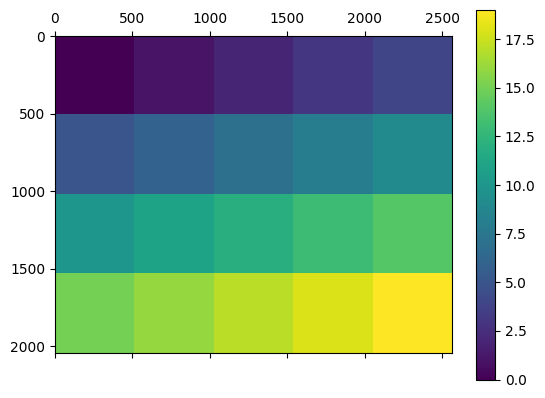

In [263]:
import matplotlib.pyplot as plt

# Define the dimensions and create the result_array as shown previously

print(result_array.shape)
# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(result_array, cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()

In [141]:
img_test2 = load_tif_image(tif_path)
print(img_test2.shape)
patch_size = 512

height_cut = (img_test2.shape[1] // patch_size) * patch_size
width_cut = (img_test2.shape[2] // patch_size) * patch_size
# img_t = img_test2[:, :height_cut, :width_cut]
print(height_cut, width_cut)


(36, 2332, 3004)
2048 2560


(2048, 2560)
(512, 512)
(20, 512, 512)
(2048, 2560)


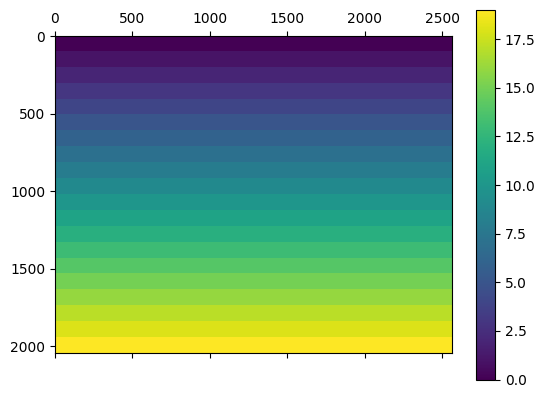

In [147]:
def extract_patches2(image: np.ndarray, patch_size: int, stride: int) -> np.ndarray:
    window_shape_array = (patch_size, patch_size)
    print(window_shape_array)
    return np.array(view_as_windows(image, window_shape_array, step=stride)).reshape((-1,) + window_shape_array)

print(result_array.shape)
patches_index = extract_patches2(result_array, patch_size=512, stride=512)
print(patches_index.shape)
img_index = patches_index.reshape(result_array.shape)
print(img_index.shape)

# Define the dimensions and create the result_array as shown previously

# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(img_index, cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()

In [160]:
for ptch in patches_index:
    print(ptch)
    print(ptch.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(512, 512)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(512, 512)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
(512, 512)
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(512, 512)
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]
(512, 512)
[[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]]
(512, 512)
[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
(512, 512)
[[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [

In [158]:
print(img_index[:64])
print(img_index[img_index == 0].shape)
print(512*512)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(262144,)
262144


In [152]:
print(result_array[:512, :512])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [161]:
# Calculate the new shape for the final result
new_shape = (result_array.shape[0], result_array.shape[1])

# Create an empty array with the original shape
reconstructed_array = np.empty(new_shape)

# Loop through the patches and place them back into the original array
for i, patch in enumerate(patches_index):
    row = (i // (new_shape[1] // patch_size[1])) * patch_size[0]
    col = (i % (new_shape[1] // patch_size[1])) * patch_size[1]
    reconstructed_array[row:row + patch_size[0], col:col + patch_size[1]] = patch

# Compare the reconstructed_array with the original result_array
print(np.array_equal(result_array, reconstructed_array))

True


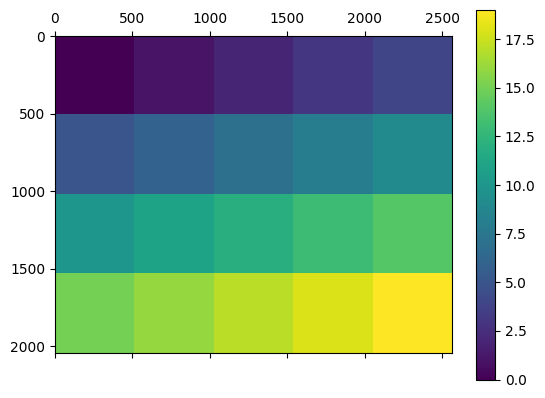

In [162]:
# Define the dimensions and create the result_array as shown previously

# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(reconstructed_array, cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()

In [260]:
a = np.array([2, 3, 5])
a[a==2] = 0
print(a)

[0 3 5]


In [5]:
from preprocess import load_tif_image, preprocess_patches, divide_pred_windows
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

# patch_size = 64
# xcut = (deter_img.shape[1] // patch_size) * patch_size
# ycut = (deter_img.shape[2] // patch_size) * patch_size

# deter_img_sample = deter_img_sample[:xcut, :ycut]
deter_img = load_tif_image('data/DETER/deter_increments_1km_1week.tif')
deter_img = deter_img[:48]
print(deter_img.shape)

deter_img_sample = deter_img[0]
mask = load_tif_image('data/IBAMA_INPE/1K/tiff_filled/mask.tif')
mask = mask[:deter_img_sample.shape[0], :deter_img_sample.shape[1]]

deter_img_sample[mask == 0] = -1
print(deter_img_sample.shape)

(48, 2333, 3005)
(2333, 3005)


In [2]:
def extract_sorted_patches(img, patch_size):
    patches = []
    for i in range(0, img.shape[0] - patch_size + 1, patch_size):
        for j in range(0, img.shape[1] - patch_size + 1, patch_size):
            patch = img[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return np.stack(patches, axis=0)

In [3]:
def reconstruct_sorted_patches(patches, img_shape, patch_size):
    img = np.zeros(img_shape)
    idx = 0
    for i in range(0, img_shape[0] - patch_size + 1, patch_size):
        for j in range(0, img_shape[1] - patch_size + 1, patch_size):
            print(idx, i, j)
            print(patches[idx].shape)
            print(img[i:i + patch_size, j:j + patch_size].shape)
            img[i:i + patch_size, j:j + patch_size] = patches[idx]
            idx += 1
    return img

In [17]:
patches = []
for t in range(0, deter_img.shape[0]):
    print(t)
    img = deter_img[t]
    patches_t = extract_sorted_patches(img, patch_size=64)
    patches.append(patches_t)
    # plt.imshow(img)
    # plt.colorbar()
    # plt.show()
    
patches = np.stack(patches, axis=0)
print(patches.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
(48, 1656, 64, 64)


In [5]:
patches_mask = []
print(mask.shape)
# for t in range(0, mask.shape[0]):
# print(t)
# img = mask[t]
print(img.shape)
patches_t = extract_sorted_patches(mask, patch_size=64)
patches_mask.append(patches_t)
    
patches_mask = np.stack(patches_mask, axis=0)
print(patches_mask.shape)

(2333, 3005)
(2333, 3005)
(1, 1656, 64, 64)


In [18]:
from preprocess import divide_pred_windows

patches = patches.transpose(1, 0, 2, 3)
windowed_patches, _, indexes = divide_pred_windows(patches, min_def=0, window_size=6, mask_patches=patches_mask[0])

print(windowed_patches.shape)

Dividing in prediction windows:   0%|          | 0/71208 [00:00<?, ?it/s]/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Dividing in prediction windows: 100%|██████████| 71208/71208 [00:07<00:00, 9578.09it/s] 


0 Skipped Images
(71208, 6, 64, 64)


In [19]:
print(indexes)
print(len(indexes))

[(0, 0, 6), (0, 1, 7), (0, 2, 8), (0, 3, 9), (0, 4, 10), (0, 5, 11), (0, 6, 12), (0, 7, 13), (0, 8, 14), (0, 9, 15), (0, 10, 16), (0, 11, 17), (0, 12, 18), (0, 13, 19), (0, 14, 20), (0, 15, 21), (0, 16, 22), (0, 17, 23), (0, 18, 24), (0, 19, 25), (0, 20, 26), (0, 21, 27), (0, 22, 28), (0, 23, 29), (0, 24, 30), (0, 25, 31), (0, 26, 32), (0, 27, 33), (0, 28, 34), (0, 29, 35), (0, 30, 36), (0, 31, 37), (0, 32, 38), (0, 33, 39), (0, 34, 40), (0, 35, 41), (0, 36, 42), (0, 37, 43), (0, 38, 44), (0, 39, 45), (0, 40, 46), (0, 41, 47), (0, 42, 48), (1, 0, 6), (1, 1, 7), (1, 2, 8), (1, 3, 9), (1, 4, 10), (1, 5, 11), (1, 6, 12), (1, 7, 13), (1, 8, 14), (1, 9, 15), (1, 10, 16), (1, 11, 17), (1, 12, 18), (1, 13, 19), (1, 14, 20), (1, 15, 21), (1, 16, 22), (1, 17, 23), (1, 18, 24), (1, 19, 25), (1, 20, 26), (1, 21, 27), (1, 22, 28), (1, 23, 29), (1, 24, 30), (1, 25, 31), (1, 26, 32), (1, 27, 33), (1, 28, 34), (1, 29, 35), (1, 30, 36), (1, 31, 37), (1, 32, 38), (1, 33, 39), (1, 34, 40), (1, 35, 41), 

In [20]:
print(indexes[-1])
print(indexes[0], indexes[42])

(1655, 42, 48)
(0, 0, 6) (0, 42, 48)


In [28]:
print(windowed_patches.shape[0] // 1656)
print(windowed_patches[:, -2:].shape)

43
(71208, 2, 64, 64)


In [29]:
patches_t = []
# 42 - 4 = 38
# 48 - 4 = 44
temporal_index = windowed_patches.shape[0] // patches.shape[0]
div_time = windowed_patches.shape[0] // temporal_index

windowed_patches = windowed_patches[:, -2:]
patches = []
for i in range(0, div_time):
    windowed_patch = windowed_patches[i * temporal_index: (i + 1) * temporal_index]
    print(windowed_patch.shape)
    # windowed_indexes = indexes[i * 46: (i + 1) * 46]
    
    init_patches = windowed_patch[0]
    print(init_patches.shape)
    non_duplicated = windowed_patch[1:, -1]
    print(init_patches.shape)
    print(non_duplicated.shape)
    patches_t = np.concatenate((init_patches, non_duplicated), axis=0)
    print(patches_t.shape)
    # patches = np.concatenate((patches, np.expand_dims(patches_t, axis=0)), axis=0)
    patches.append(patches_t)
    # print(patches.shape)
patches = np.stack(patches, axis=0)
print(patches.shape)

(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64, 64)
(2, 64, 64)
(2, 64, 64)
(42, 64, 64)
(44, 64, 64)
(43, 2, 64

In [30]:
img_reconstructed = reconstruct_sorted_patches(patches[:, 0], (2333, 3005), patch_size=64)

0 0 0
(64, 64)
(64, 64)
1 0 64
(64, 64)
(64, 64)
2 0 128
(64, 64)
(64, 64)
3 0 192
(64, 64)
(64, 64)
4 0 256
(64, 64)
(64, 64)
5 0 320
(64, 64)
(64, 64)
6 0 384
(64, 64)
(64, 64)
7 0 448
(64, 64)
(64, 64)
8 0 512
(64, 64)
(64, 64)
9 0 576
(64, 64)
(64, 64)
10 0 640
(64, 64)
(64, 64)
11 0 704
(64, 64)
(64, 64)
12 0 768
(64, 64)
(64, 64)
13 0 832
(64, 64)
(64, 64)
14 0 896
(64, 64)
(64, 64)
15 0 960
(64, 64)
(64, 64)
16 0 1024
(64, 64)
(64, 64)
17 0 1088
(64, 64)
(64, 64)
18 0 1152
(64, 64)
(64, 64)
19 0 1216
(64, 64)
(64, 64)
20 0 1280
(64, 64)
(64, 64)
21 0 1344
(64, 64)
(64, 64)
22 0 1408
(64, 64)
(64, 64)
23 0 1472
(64, 64)
(64, 64)
24 0 1536
(64, 64)
(64, 64)
25 0 1600
(64, 64)
(64, 64)
26 0 1664
(64, 64)
(64, 64)
27 0 1728
(64, 64)
(64, 64)
28 0 1792
(64, 64)
(64, 64)
29 0 1856
(64, 64)
(64, 64)
30 0 1920
(64, 64)
(64, 64)
31 0 1984
(64, 64)
(64, 64)
32 0 2048
(64, 64)
(64, 64)
33 0 2112
(64, 64)
(64, 64)
34 0 2176
(64, 64)
(64, 64)
35 0 2240
(64, 64)
(64, 64)
36 0 2304
(64, 64)
(6

(2333, 3005)


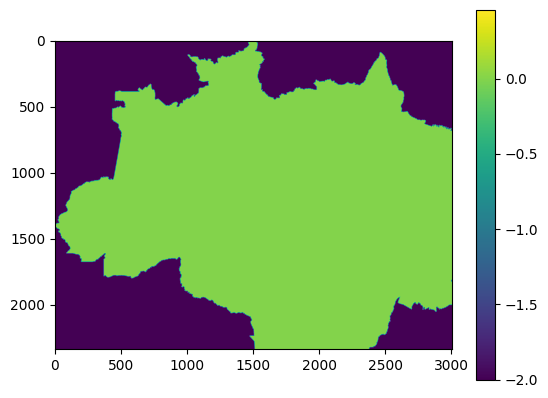

In [31]:
print(img_reconstructed.shape)
img_reconstructed[mask == 0] = -2
# deter_img[0][mask == 0] = -1
plt.imshow(img_reconstructed)
plt.colorbar()
plt.show()

(48, 2333, 3005)


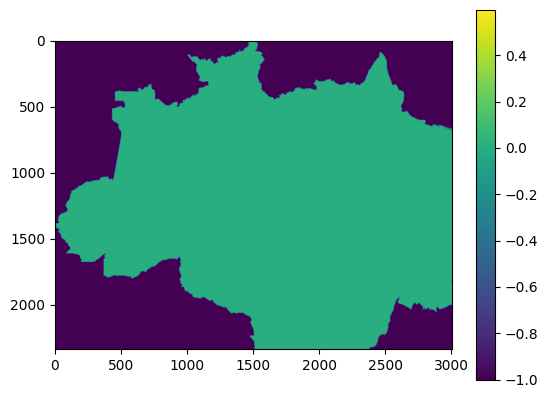

In [14]:
print(deter_img.shape)
# img_reconstructed[mask == 0] = -1
deter_img[0][mask == 0] = -1
plt.imshow(deter_img[0])
plt.colorbar()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_reconstructed = np.load('work_dirs/custom_exp10/reconstructed_images.npy')

(48, 2333, 3005)


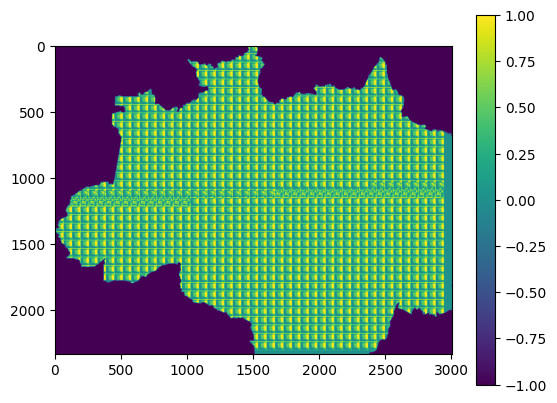

In [8]:
print(img_reconstructed.shape)
img_sample = img_reconstructed[1]
img_sample[mask == 0] = -1
plt.imshow(img_sample)
plt.colorbar()
plt.show()

In [9]:
def_preds_reconstructed = np.load('work_dirs/custom_exp10/def_reconstructed_images.npy')

(48, 2333, 3005)


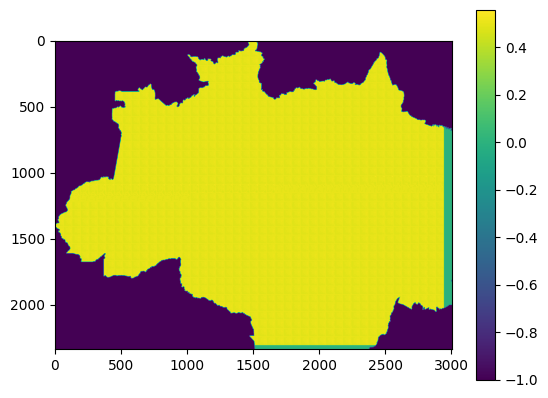

In [10]:
print(def_preds_reconstructed.shape)
img_sample = def_preds_reconstructed[1]
img_sample[mask == 0] = -1
plt.imshow(img_sample)
plt.colorbar()
plt.show()